In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as ep

ep.update_plot_defaults()

- Export the weights along the trajectory for both models
- combine
- PCA
- interpolate (+- 10%)
- create set of weights
- probe loss of both networks
    - convert BP net to ReLU before computing loss
- plot 2D loss landscape as 3D heatmap (including 2 actual trajectories, plot separately)

In [2]:
input_size = 21
dataset = torch.eye(input_size)
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), shuffle=True, generator=data_generator)

test_dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                             batch_size = 21,
                             generator=data_generator)
epochs=30
seed=42

### Gjorgjieva learning rule

In [3]:
network_config = ut.read_from_yaml('../optimize/data/20220902_EIANN_1_hidden_Gjorgieva_Hebb_config_A.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

gj_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

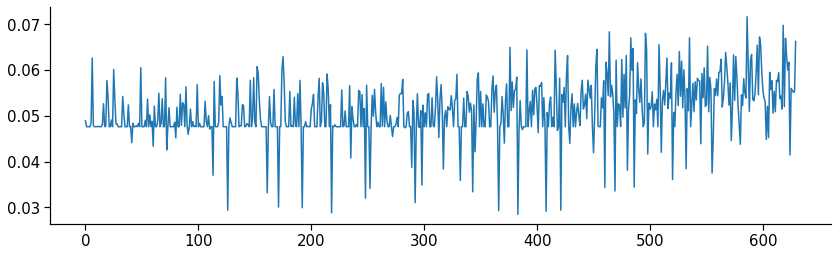

In [4]:
data_generator.manual_seed(data_seed)
gj_network.train(dataloader, epochs, store_history=True, status_bar=True)

plt.plot(gj_network.loss_history)
plt.show()

In [6]:
def gini(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(sorted_x, dtype=float)
    gini_coefficient = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n    
    return gini_coefficient 

def get_diag_sorting(network, activity_matrix, target):
    # Compute Gini coefficients for all units
    num_units = activity_matrix.shape[1]
    selectivity_ls = []
    for i in range(num_units):
        unit_activity = activity_matrix[:,i]
        selectivity_ls.append(gini(unit_activity))
    
    # Starting from highest Gini, position each unit according to its argmax
        # if the preferred position is taken, set argmax=0, recompute Gini, put unit back in the list
    
    sorted_activity = torch.zeros_like(activity_matrix)
    _activity_matrix = torch.clone(activity_matrix)
    for i in range(num_units):
        most_selective = np.argmax(selectivity_ls)
        unit_activity = activity_matrix[:,most_selective]
        unit_preference = np.argmax(unit_activity)
        if torch.all(sorted_activity[:,unit_preference]==0): #if spot is not taken
            sorted_activity[:,unit_preference] = unit_activity
        else:      
            
    return optimal_sorting
        

In [8]:
network = gj_network

# 1. Measure test loss on re-sorted activity at every point in the training history
output_layer = list(network)[-1]
output_pop = output_layer.E

optimal_loss_history = []
sorting_history = []
history_len = output_pop.activity_history.shape[0]
for i in range(history_len):
    state_dict = network.param_history[i]
    network_snapshot = Network(layer_config, projection_config, seed=seed, **training_kwargs)
    network_snapshot.load_state_dict(state_dict)
    
    idx, test_data, test_target = next(iter(test_dataloader)) #requires dataloader with single large batch
    output = network_snapshot.forward(test_data)
    
    # Get average output for each label class
    avg_output = torch.zeros_like(output)
    for label in range(test_target.shape[1]):
        targets = torch.argmax(test_target,dim=1)
        label_idx = torch.where(label==targets)    
        avg_output[label,:] = torch.mean(output[label_idx],dim=0)
    
    # Find optimal output unit sorting given average responses
    optimal_sorting = ut.get_diag_argmax_row_indexes(avg_output)
#     optimal_loss, optimal_sorting = get_optimal_sorting(network, avg_output, test_target)
    optimal_loss = network.criterion(avg_output[optimal_sorting],test_target)
    
    optimal_loss_history.append(optimal_loss)
    sorting_history.append(optimal_sorting)
         
# 2. Pick timepoint with lowest sorted loss and apply sorting to output activity history
min_loss_idx = torch.argmin(torch.tensor(optimal_loss_history))
min_loss_sorting = sorting_history[min_loss_idx]

output_pop.activity_history.data = output_pop.activity_history[:,:,min_loss_sorting]

# 3. Re-compute loss history with new sorting
for i in range(history_len):
    output = output_pop.activity_history[i,-1,:]
    target = network.target_history[i]
    network.loss_history[i] = network.criterion(output,target)
    
# 4. Re-sort weight matrices going to and from the output population


In [9]:
output_pop.projections

{'H1': {'E': Projection(in_features=7, out_features=21, bias=False)},
 'Output': {'FBI': Projection(in_features=7, out_features=21, bias=False)}}

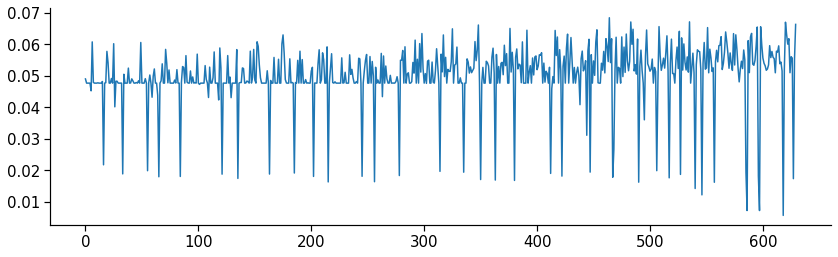

tensor(609)


In [10]:
plt.plot(network.loss_history)
plt.show()
print(min_loss_idx)

In [11]:



# # 3. Compute loss landscape on new weight history



# final_output = output_pop.activity_history[network.sorted_sample_indexes, -1, :][-target.shape[0]:, :].T
# sorted_idx = get_diag_argmax_row_indexes(final_output)
# loss_history = []
# for i in range(output_pop.activity_history.shape[0]):
#     sample_idx = network.sample_order[i]
#     sample_target = target[sample_idx, :]
#     output = output_pop.activity_history[i, -1, sorted_idx]
#     loss = network.criterion(output, sample_target)
#     loss_history.append(loss)
#     argmax_correct.append(torch.argmax(output) == torch.argmax(sample_target))
# loss_history = torch.tensor(loss_history)
# argmax_correct = torch.tensor(argmax_correct)

# epoch_argmax_accuracy = []
# start = 0
# while start < len(argmax_correct):
#     epoch_argmax_accuracy.append(torch.sum(argmax_correct[start:start+target.shape[0]]) / target.shape[0] * 100.)
#     start += target.shape[0]

# epoch_argmax_accuracy = torch.tensor(epoch_argmax_accuracy)


In [12]:
ep.plot_weight_history_PCs(gj_network)

AttributeError: 'Projection' object has no attribute 'weight_history'

In [ ]:
ds = [x for x in zip(dataset,target)]
test_dataloader = DataLoader(ds, batch_size=1)
ep.plot_loss_landscape(gj_network, test_dataloader, num_points=20)

### Backprop (softplus; SGD)

In [ ]:
network_config = ut.read_from_yaml('../config/EIANN_1_hidden_backprop_softplus_SGD_matched_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

In [ ]:
# Initialize backprop net with same weights as Gjorg. init
for i,gj_projection in enumerate(gj_network.module_list):
    bp_network.module_list[i].weight.data = gj_projection.weight_history[0].clone()

# for gj_layer,bp_layer in zip(gj_network,bp_network):
#     for gj_pop,bp_pop in zip(gj_layer,bp_layer):
#         for gj_proj,bp_proj in zip(gj_pop,bp_pop):
#             bp_proj.weight.data = gj_proj.weight_history[0].clone()

In [ ]:
data_generator.manual_seed(data_seed)
bp_network.train(dataloader, epochs, store_history=True, status_bar=True)

plt.plot(bp_network.loss_history)
plt.show()

In [ ]:
ep.plot_weight_history_PCs(bp_network)

In [ ]:
ep.plot_loss_landscape(bp_network, test_dataloader, num_points=20)

## Combined loss landscape

In [ ]:
ep.plot_combined_loss_landscape(gj_network, bp_network, test_dataloader, num_points=20)